In [1]:
%pylab inline
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision import transforms

from PIL import Image
from typing import List

Populating the interactive namespace from numpy and matplotlib


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_dir = "Images"
model_dir = "Models"

image_size = 512
imagenet_mean = [0.40760392, 0.45795686, 0.48501961]
imagenet_std = [1, 1, 1]
rgb_bgr_fn = lambda x: x[[2, 1, 0], :]

prep = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Lambda(rgb_bgr_fn),  # turn to BGR
        transforms.Normalize(
            mean=imagenet_mean, std=imagenet_std  # subtract imagenet mean
        ),
        transforms.Lambda(lambda x: x.mul_(255)),
    ]
)

postpa = transforms.Compose(
    [
        transforms.Lambda(lambda x: x.div_(255)),
        transforms.Normalize(
            mean=[-i for i in imagenet_mean], std=imagenet_std  # add imagenet mean
        ),
        transforms.Lambda(rgb_bgr_fn),  # turn to RGB
        transforms.Lambda(
            lambda x: torch.clamp_(x, 0, 1)  # to clip results in the range [0,1]
        ),
        transforms.ToPILImage(),
    ]
)

In [3]:
class VGG(nn.Module):
    def __init__(self, pool: str = "max") -> None:
        super(VGG, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == "max":
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == "avg":
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor, out_keys: List[str]) -> List[torch.Tensor]:
        out = {}
        out["r11"] = F.relu(self.conv1_1(x))
        out["r12"] = F.relu(self.conv1_2(out["r11"]))
        out["p1"] = self.pool1(out["r12"])
        out["r21"] = F.relu(self.conv2_1(out["p1"]))
        out["r22"] = F.relu(self.conv2_2(out["r21"]))
        out["p2"] = self.pool2(out["r22"])
        out["r31"] = F.relu(self.conv3_1(out["p2"]))
        out["r32"] = F.relu(self.conv3_2(out["r31"]))
        out["r33"] = F.relu(self.conv3_3(out["r32"]))
        out["r34"] = F.relu(self.conv3_4(out["r33"]))
        out["p3"] = self.pool3(out["r34"])
        out["r41"] = F.relu(self.conv4_1(out["p3"]))
        out["r42"] = F.relu(self.conv4_2(out["r41"]))
        out["r43"] = F.relu(self.conv4_3(out["r42"]))
        out["r44"] = F.relu(self.conv4_4(out["r43"]))
        out["p4"] = self.pool4(out["r44"])
        out["r51"] = F.relu(self.conv5_1(out["p4"]))
        out["r52"] = F.relu(self.conv5_2(out["r51"]))
        out["r53"] = F.relu(self.conv5_3(out["r52"]))
        out["r54"] = F.relu(self.conv5_4(out["r53"]))
        out["p5"] = self.pool5(out["r54"])
        return [out[key] for key in out_keys]

In [4]:
vgg = torch.jit.script(VGG())
# vgg = VGG()
vgg.load_state_dict(torch.load(os.path.join(model_dir, "vgg_conv.pth")))
vgg.to(device).eval()

RecursiveScriptModule(
  original_name=VGG
  (conv1_1): RecursiveScriptModule(original_name=Conv2d)
  (conv1_2): RecursiveScriptModule(original_name=Conv2d)
  (conv2_1): RecursiveScriptModule(original_name=Conv2d)
  (conv2_2): RecursiveScriptModule(original_name=Conv2d)
  (conv3_1): RecursiveScriptModule(original_name=Conv2d)
  (conv3_2): RecursiveScriptModule(original_name=Conv2d)
  (conv3_3): RecursiveScriptModule(original_name=Conv2d)
  (conv3_4): RecursiveScriptModule(original_name=Conv2d)
  (conv4_1): RecursiveScriptModule(original_name=Conv2d)
  (conv4_2): RecursiveScriptModule(original_name=Conv2d)
  (conv4_3): RecursiveScriptModule(original_name=Conv2d)
  (conv4_4): RecursiveScriptModule(original_name=Conv2d)
  (conv5_1): RecursiveScriptModule(original_name=Conv2d)
  (conv5_2): RecursiveScriptModule(original_name=Conv2d)
  (conv5_3): RecursiveScriptModule(original_name=Conv2d)
  (conv5_4): RecursiveScriptModule(original_name=Conv2d)
  (pool1): RecursiveScriptModule(original_nam

In [5]:
def gram_matrix(tensor: torch.Tensor) -> torch.Tensor:
    b, c, h, w = tensor.size()
    F = tensor.view(b, c, h * w)
    G = torch.bmm(F, F.transpose(1, 2))
    return G.div(h * w)


# https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
class StyleLoss(nn.Module):
    def __init__(self, target_feature: torch.Tensor) -> None:
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        G = gram_matrix(tensor)
        loss = F.mse_loss(G, self.target)
        return loss


class ContentLoss(nn.Module):
    def __init__(self, target: torch.Tensor) -> None:
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        loss = F.mse_loss(tensor, self.target)
        return loss

In [6]:
# load images, ordered as [style_image, content_image]
img_names = ["vangogh_starry_night.jpg", "Tuebingen_Neckarfront.jpg"]
imgs = list(map(lambda x: Image.open(os.path.join(image_dir, x)), img_names))

img_fn = lambda x: prep(x).unsqueeze(0).to(device, torch.float)
imgs_torch = list(map(img_fn, imgs))
style_image, content_image = imgs_torch

opt_img = content_image.clone().detach().requires_grad_(True)
# opt_img = torch.randn(content_image.size()).to(device, torch.float).detach().requires_grad_(True)  # random init

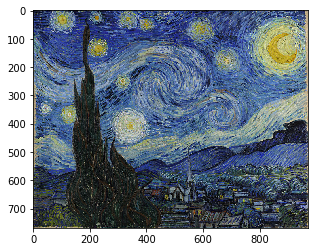

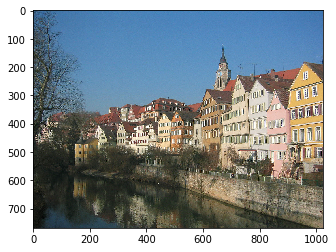

In [7]:
# display images
for img in imgs:
    imshow(img)
    show()

In [8]:
style_layers = ["r11", "r21", "r31", "r41", "r51"]
content_layers = ["r42"]

style_weights = [1e3 / n ** 2 for n in [64, 128, 256, 512, 512]]
content_weights = [1e0]
weights = style_weights + content_weights

loss_layers = style_layers + content_layers
loss_fns = [StyleLoss(x).to(device) for x in vgg(style_image, style_layers)]
loss_fns.extend([ContentLoss(x).to(device) for x in vgg(content_image, content_layers)])

Iteration:   50,    loss: 1167918.12,    time/step: 0.127s  
Iteration:  100,    loss:  598304.38,    time/step: 0.135s  
Iteration:  150,    loss:  442706.44,    time/step: 0.141s  
Iteration:  200,    loss:  385129.75,    time/step: 0.143s  
Iteration:  250,    loss:  356083.41,    time/step: 0.145s  
Iteration:  300,    loss:  337551.38,    time/step: 0.146s  
Iteration:  350,    loss:  325130.69,    time/step: 0.147s  
Iteration:  400,    loss:  316354.41,    time/step: 0.148s  
Iteration:  450,    loss:  309749.81,    time/step: 0.148s  
Iteration:  500,    loss:  304451.03,    time/step: 0.149s  


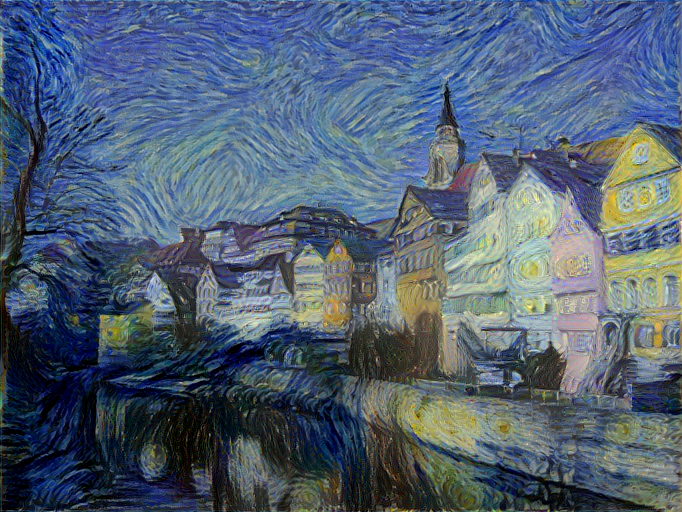

In [9]:
max_iter = 500
show_iter = 50
optimizer = optim.LBFGS([opt_img])
n_iter = [0]

start_time = time.perf_counter()
while n_iter[0] <= max_iter:

    def closure() -> torch.Tensor:
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [w * l(o) for w, l, o in zip(weights, loss_fns, out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0] += 1
        if n_iter[0] % show_iter == (show_iter - 1):
            print(
                f"Iteration: {n_iter[0] + 1:4d},    loss: {loss.item():10.2f},    "
                f"time/step: {(time.perf_counter() - start_time) / n_iter[0]:.3f}s  "
            )
        return loss

    optimizer.step(closure)

out_img = postpa(opt_img.data.cpu().squeeze())
out_img
# imshow(out_img)
# gcf().set_size_inches(10,10)

Make the image high-resolution as described in "Controlling Perceptual Factors in Neural Style Transfer", Gatys et al. (https://arxiv.org/abs/1611.07865)

In [10]:
# hr preprocessing
img_size_hr = 800  # works for 8GB GPU, make larger if you have 12GB or more
prep_hr = transforms.Compose(
    [
        transforms.Resize(img_size_hr),
        transforms.ToTensor(),
        transforms.Lambda(rgb_bgr_fn),  # turn to BGR
        transforms.Normalize(
            mean=imagenet_mean, std=imagenet_std  # subtract imagenet mean
        ),
        transforms.Lambda(lambda x: x.mul_(255)),
    ]
)

# prep hr images
img_fn = lambda x: prep_hr(x).unsqueeze(0).to(device, torch.float)
imgs_torch = list(map(img_fn, imgs))
style_image, content_image = imgs_torch

# now initialise with upsampled lowres result
opt_img = prep_hr(out_img).unsqueeze(0).to(device, torch.float)
opt_img = opt_img.clone().detach().requires_grad_(True)

loss_fns = [StyleLoss(x).to(device) for x in vgg(style_image, style_layers)]
loss_fns.extend([ContentLoss(x).to(device) for x in vgg(content_image, content_layers)])

Iteration:   50,    loss:  422225.12,    time/step: 0.313s  
Iteration:  100,    loss:  326257.56,    time/step: 0.326s  
Iteration:  150,    loss:  293079.59,    time/step: 0.336s  
Iteration:  200,    loss:  275467.75,    time/step: 0.341s  


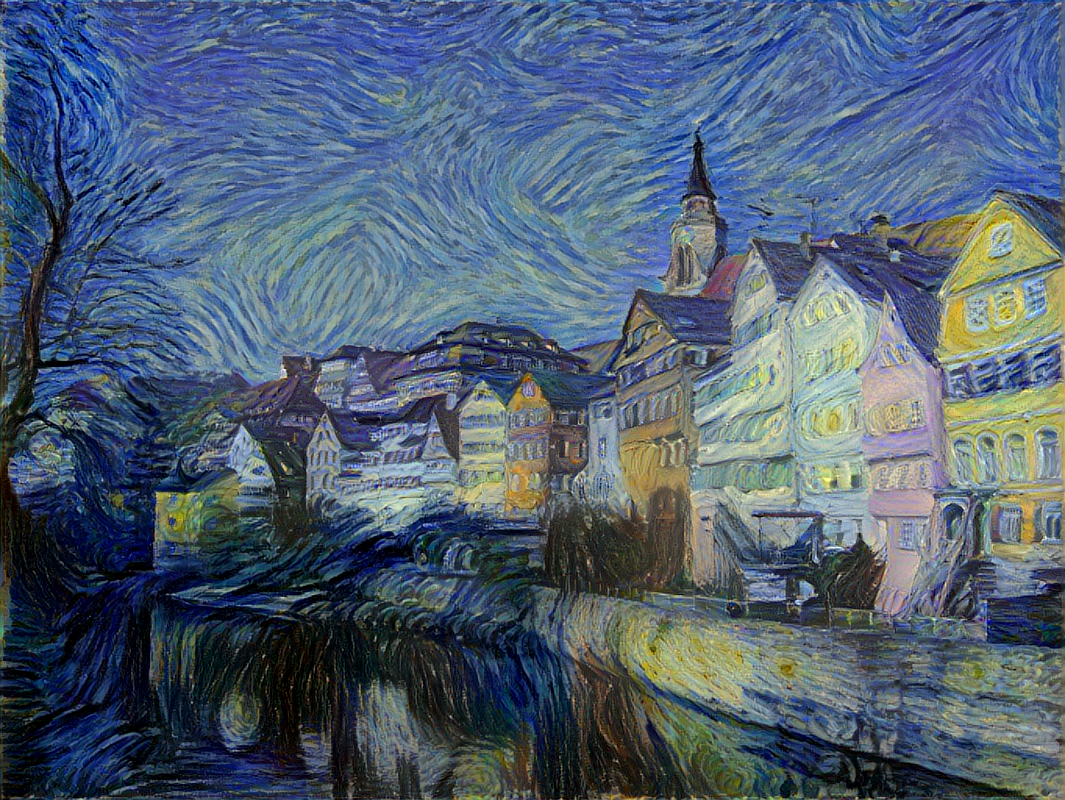

In [11]:
max_iter_hr = 200
optimizer = optim.LBFGS([opt_img])
n_iter = [0]

start_time = time.perf_counter()
while n_iter[0] <= max_iter_hr:

    def closure() -> torch.Tensor:
        optimizer.zero_grad()
        out = vgg(opt_img, loss_layers)
        layer_losses = [w * l(o) for w, l, o in zip(weights, loss_fns, out)]
        loss = sum(layer_losses)
        loss.backward()
        n_iter[0] += 1
        if n_iter[0] % show_iter == (show_iter - 1):
            print(
                f"Iteration: {n_iter[0] + 1:4d},    loss: {loss.item():10.2f},    "
                f"time/step: {(time.perf_counter() - start_time) / n_iter[0]:.3f}s  "
            )
        return loss

    optimizer.step(closure)

out_img_hr = postpa(opt_img.data.cpu().squeeze())
out_img_hr
# imshow(out_img_hr)
# gcf().set_size_inches(10,10)